## Download mail data

In [2]:
%matplotlib inline
import email, getpass, imaplib, os
import pandas as pd
import smtplib
from email.mime.text import MIMEText

In [3]:
all_emails = []

In [4]:
# Takes ~30 seconds to run

detach_dir = '.' # directory where to save attachments (default: current)
user = raw_input("Enter your GMail username:")
pwd = getpass.getpass("Enter your password: ")

# connecting to the gmail imap server
m = imaplib.IMAP4_SSL("imap.gmail.com")
m.login(user,pwd)
m.select("[Gmail]/Spam") # here you a can choose a mail box like INBOX instead
# use m.list() to get all the mailboxes

resp, items = m.search(None, "ALL") # you could filter using the IMAP rules here (check http://www.example-code.com/csharp/imap-search-critera.asp)
items = items[0].split() # getting the mails id

for emailid in items:
    resp, data = m.fetch(emailid, "(RFC822)") # fetching the mail, "`(RFC822)`" means "get the whole stuff", but you can ask for headers only, etc
    # Alternatives to RFC822: https://books.google.com/books?id=lDS_DgAAQBAJ&pg=PT255&lpg=PT255&dq=RFC822+header+only&source=bl&ots=woHx-uu7B3&sig=hSKWo7eRCidc652sCeGfFQdGtCo&hl=en&sa=X&ved=0ahUKEwiPqZvGoJrZAhWM7oMKHVxzAmkQ6AEIPDAD#v=onepage&q=RFC822%20header%20only&f=false
    
    for response_part in data:
        if isinstance(response_part, tuple):
            msg = email.message_from_string(response_part[1])
            email_subject = msg['subject']
            email_from = msg['from']
#             if msg.is_multipart():
#                 for payload in msg.get_payload():
#                     print(payload.get_payload())
#             else:
#                 print(msg.get_payload())
            all_emails.append([email_subject, 'spam'])
    
#     email_body = data[0][1] # getting the mail content
#     #Check if its already there
#     att_path = "spam" + emailid + ".txt"
#     if not os.path.isfile(att_path) :
#         # finally write the stuff
#         fp = open(att_path, 'wb')
#         fp.write(email_body)
#         fp.close()

Enter your GMail username:nam.kolla
Enter your password: ········


In [5]:
# Takes ~5 minutes to run

detach_dir = '.' # directory where to save attachments (default: current)
user = raw_input("Enter your GMail username:")
pwd = getpass.getpass("Enter your password: ")

# connecting to the gmail imap server
m = imaplib.IMAP4_SSL("imap.gmail.com")
m.login(user,pwd)
m.select("INFX") # here you a can choose a mail box like INBOX instead
# use m.list() to get all the mailboxes
resp, items = m.search(None,"All") # you could filter using the IMAP rules here (check http://www.example-code.com/csharp/imap-search-critera.asp)
items = items[0].split() # getting the mails id

for emailid in items:
    resp, data = m.fetch(emailid, "(RFC822)") # fetching the mail, "`(RFC822)`" means "get the whole stuff", but you can ask for headers only, etc
    
    for response_part in data:
        if isinstance(response_part, tuple):
            msg = email.message_from_string(response_part[1])
            email_subject = msg['subject']
            email_from = msg['from']
#             if msg.is_multipart():
#                 for payload in msg.get_payload():
#                     print(payload.get_payload())
#             else:
#                 print(msg.get_payload())
            all_emails.append([email_subject, 'not_spam'])

Enter your GMail username:nam.kolla
Enter your password: ········


## Scrape txt files for messages and create one dataframe

In [6]:
# Confirm text of all emails were downloaded
len(all_emails)

762

In [7]:
all_emails = pd.DataFrame(all_emails, columns = ['message','label'])

In [8]:
all_emails.groupby('label').describe()

message
label                                    
not_spam count                        673
         unique                       329
         top     Re: Carbon Panel Updates
         freq                          44
spam     count                         89
         unique                        67
         top           Product of the day
         freq                           7

Observations: 
* Many more spam than not-spam email
* More of the spam headers are unique than not-spam
* Not-spam email have a higher likelihood of being repetitive

## Look around, add new variable length

In [9]:
all_emails['length'] = all_emails['message'].map(lambda text: len(text))
print(all_emails.head())

                                             message label  length
0                Aced a class? Get paid for your A's  spam      35
1  =?utf-8?Q?Bat=27s=20echolocation=20could=20ins...  spam     113
2  Become a Leader in the Library and Info Scienc...  spam      53
3             Advance Your Career with an Online MBA  spam      38
4  =?UTF-8?Q?Romantic_Gifts_=E2=9D=A4_For_your_Va...  spam      71


In [10]:
import matplotlib.pyplot as plt

(0, 250)

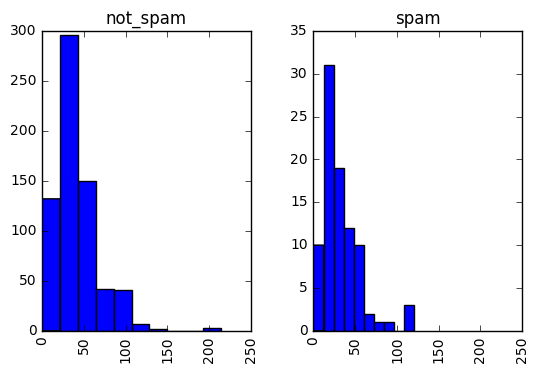

In [11]:
all_emails.hist(column='length', by='label', bins=10)
plt.xlim((0,250))

## Data pre-processing, bag-of-words approach

In [12]:
from textblob import TextBlob

In [13]:
def split_into_tokens(message):
    message = unicode(message, 'utf8')  # convert bytes into proper unicode
    return TextBlob(message).words

def split_into_lemmas(message):
    message = unicode(message, 'utf8').lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

In [14]:
all_emails.message.head().apply(split_into_tokens)

0        [Aced, a, class, Get, paid, for, your, A, 's]
1    [utf-8, Q, Bat=27s=20echolocation=20could=20in...
2    [Become, a, Leader, in, the, Library, and, Inf...
3       [Advance, Your, Career, with, an, Online, MBA]
4    [UTF-8, Q, Romantic_Gifts_=E2=9D=A4_For_your_V...
Name: message, dtype: object

In [15]:
all_emails.message.head().apply(split_into_lemmas)

0        [aced, a, class, get, paid, for, your, a, 's]
1    [utf-8, q, bat=27s=20echolocation=20could=20in...
2    [become, a, leader, in, the, library, and, inf...
3       [advance, your, career, with, an, online, mba]
4    [utf-8, q, romantic_gifts_=e2=9d=a4_for_your_v...
Name: message, dtype: object

## Splitting data for training and testing

In [16]:
import random
import numpy as np

import sklearn 
import cPickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

In [17]:
np.random.seed(seed=900)
all_emails['rand'] = all_emails.apply(lambda row: random.random(), axis=1)
    # put 66% of data in training; 33% in testing
all_emails['train'] = all_emails['rand']>.33

In [18]:
emails_train = all_emails[all_emails['train']==True]
emails_test = all_emails[all_emails['train']==False]

In [19]:
emails_train = emails_train.reset_index(drop=True)

In [20]:
emails_test = emails_test.reset_index(drop=True)

In [21]:
print(len(emails_train))
print(len(emails_test))

495
267


In [22]:
emails_train.describe()
emails_test.describe()

,length,rand
count,267.000000,267.000000
mean,41.378277,0.164002
std,26.577790,0.093705
min,0.000000,0.000815
25%,24.000000,0.085073
50%,35.000000,0.168597
75%,56.000000,0.243742
max,214.000000,0.326796


In [23]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [24]:
emails_train.head()

,message,label,length,rand,train
0,=?utf-8?Q?Bat=27s=20echolocation=20could=20ins...,spam,113,0.878763,True
1,Become a Leader in the Library and Info Scienc...,spam,53,0.880546,True
2,Advance Your Career with an Online MBA,spam,38,0.582425,True
3,How did they do it? Meet the Innovation winner...,spam,56,0.696711,True
4,,spam,0,0.849265,True


## Naive-Bayes

Algorithm info: http://ats.cs.ut.ee/u/kt/hw/spam/spam.pdf

### Data to vectors

In [25]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(emails_train['message'])

In [26]:
print len(bow_transformer.vocabulary_)

629


In [27]:
messages_bow_tr = bow_transformer.transform(emails_train['message'])
tfidf_transformer_tr = TfidfTransformer().fit(messages_bow_tr)
messages_tfidf_tr = tfidf_transformer_tr.transform(messages_bow_tr)

In [28]:
messages_tfidf_tr.shape

(495, 629)

In [29]:
#lab_rshp = np.reshape(emails_train['label'],(len(emails_train['label']),1))

### Train model

In [30]:
from scipy import sparse
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [31]:
%time spam_detector = MultinomialNB().fit(messages_tfidf_tr,emails_train['label'])
# %time spam_detector = MultinomialNB().fit([messages_tfidf_tr,sparse.csc_matrix(emails_train['length'])],lab_rshp)

CPU times: user 4.59 ms, sys: 1.81 ms, total: 6.41 ms
Wall time: 5.9 ms


In [32]:
messages_tfidf_tr

<495x629 sparse matrix of type '<type 'numpy.float64'>'
	with 2951 stored elements in Compressed Sparse Row format>

In [33]:
print 'predicted:', spam_detector.predict(messages_tfidf_tr)[30]
print 'expected:', emails_train.label[30]

predicted: spam
expected: spam


In [34]:
print(spam_detector.predict(messages_tfidf_tr)[:10])

['not_spam' 'not_spam' 'spam' 'spam' 'not_spam' 'not_spam' 'spam'
 'not_spam' 'spam' 'not_spam']


In [35]:
emails_train.label[:10]

0    spam
1    spam
2    spam
3    spam
4    spam
5    spam
6    spam
7    spam
8    spam
9    spam
Name: label, dtype: object

In [36]:
trained_predictions = spam_detector.predict(messages_tfidf_tr)

In [37]:
print 'accuracy', accuracy_score(emails_train['label'], trained_predictions)
print 'confusion matrix\n', confusion_matrix(emails_train['label'], trained_predictions)
print '(row=expected, col=predicted)'

accuracy 0.939393939394
confusion matrix
[[436   1]
 [ 29  29]]
(row=expected, col=predicted)


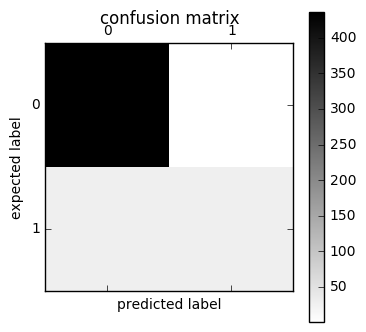

In [38]:
plt.matshow(confusion_matrix(emails_train['label'], trained_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [39]:
print classification_report(emails_train['label'], trained_predictions)

             precision    recall  f1-score   support

   not_spam       0.94      1.00      0.97       437
       spam       0.97      0.50      0.66        58

avg / total       0.94      0.94      0.93       495



### Test model

In [40]:
bow_transformer_te = CountVectorizer(analyzer=split_into_lemmas).fit(emails_test['message'])

In [55]:
messages_bow_te = bow_transformer.transform(emails_test['message'])
tfidf_transformer_te = TfidfTransformer().fit(messages_bow_te)
messages_tfidf_te = tfidf_transformer_te.transform(messages_bow_te)

In [56]:
test_predictions = spam_detector.predict(messages_tfidf_te)

In [57]:
# DEBUGGING OTHER CODE: 

print(messages_tfidf_te.shape)
print(messages_tfidf_tr.shape)

(267, 629)
(495, 629)


In [43]:
print 'accuracy', accuracy_score(emails_test['label'], test_predictions)
print 'confusion matrix\n', confusion_matrix(emails_test['label'], test_predictions)
print '(row=expected, col=predicted)'

accuracy 0.921348314607
confusion matrix
[[236   0]
 [ 21  10]]
(row=expected, col=predicted)


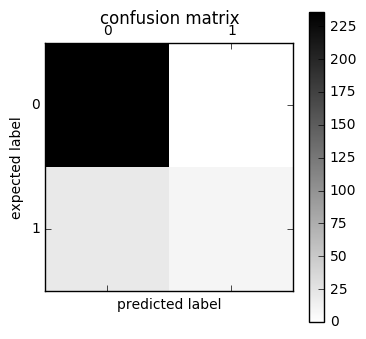

In [44]:
plt.matshow(confusion_matrix(emails_test['label'], test_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [45]:
print classification_report(emails_test['label'], test_predictions)

             precision    recall  f1-score   support

   not_spam       0.92      1.00      0.96       236
       spam       1.00      0.32      0.49        31

avg / total       0.93      0.92      0.90       267



## kNN 

Algorithm info: http://ats.cs.ut.ee/u/kt/hw/spam/spam.pdf

### Train model

In [80]:
from sklearn.neighbors import KNeighborsClassifier

In [81]:
neigh = KNeighborsClassifier(n_neighbors=3)

In [82]:
neigh.fit(messages_tfidf_tr,emails_train['label'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [83]:
print 'predicted:', neigh.predict(messages_tfidf_tr)[41]
print 'expected:', emails_train.label[41]

predicted: spam
expected: spam


In [84]:
knn_trained_predictions = neigh.predict(messages_tfidf_tr)

In [85]:
print 'accuracy', accuracy_score(emails_train['label'], knn_trained_predictions)
print 'confusion matrix\n', confusion_matrix(emails_train['label'], knn_trained_predictions)
print '(row=expected, col=predicted)'

accuracy 0.952286282306
confusion matrix
[[443   8]
 [ 16  36]]
(row=expected, col=predicted)


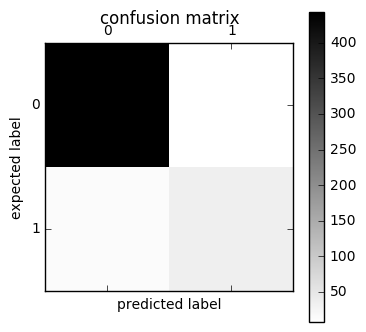

In [86]:
plt.matshow(confusion_matrix(emails_train['label'], knn_trained_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [87]:
print classification_report(emails_train['label'], knn_trained_predictions)

             precision    recall  f1-score   support

   not_spam       0.97      0.98      0.97       451
       spam       0.82      0.69      0.75        52

avg / total       0.95      0.95      0.95       503



### Test model

In [88]:
knn_test_predictions = neigh.predict(messages_tfidf_te)

In [89]:
print 'accuracy', accuracy_score(emails_test['label'], knn_test_predictions)
print 'confusion matrix\n', confusion_matrix(emails_test['label'], knn_test_predictions)
print '(row=expected, col=predicted)'

accuracy 0.929133858268
confusion matrix
[[222   4]
 [ 14  14]]
(row=expected, col=predicted)


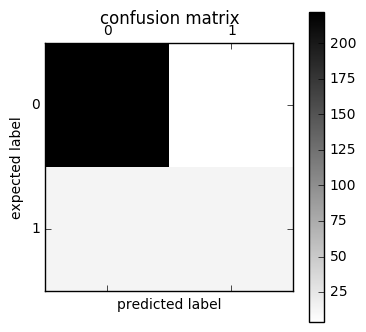

In [90]:
plt.matshow(confusion_matrix(emails_test['label'], knn_test_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [91]:
print classification_report(emails_test['label'], knn_test_predictions)

             precision    recall  f1-score   support

   not_spam       0.94      0.98      0.96       226
       spam       0.78      0.50      0.61        28

avg / total       0.92      0.93      0.92       254



## Compare AUCs

In [93]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [94]:
# Naive Bayes - Training Data

emails_train['label'][emails_train['label']=='spam'] = 1
emails_train['label'][emails_train['label']=='not_spam'] = 0
trained_predictions[trained_predictions=='spam'] = 1
trained_predictions[trained_predictions=='not_spam'] = 0
trained_predictions = map(int, trained_predictions)

false_positive_rate, true_positive_rate, thresholds = roc_curve(emails_train['label'], trained_predictions)
print auc(false_positive_rate, true_positive_rate)

0.758506737165


/Users/namratakolla/anaconda/envs/DAND/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/namratakolla/anaconda/envs/DAND/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [95]:
# Naive Bayes - Test Data

emails_test['label'][emails_test['label']=='spam'] = 1
emails_test['label'][emails_test['label']=='not_spam'] = 0
test_predictions[test_predictions=='spam'] = 1
test_predictions[test_predictions=='not_spam'] = 0
test_predictions = map(int, test_predictions)

false_positive_rate, true_positive_rate, thresholds = roc_curve(emails_test['label'], test_predictions)
print auc(false_positive_rate, true_positive_rate)

0.607142857143


/Users/namratakolla/anaconda/envs/DAND/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/namratakolla/anaconda/envs/DAND/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [105]:
# kNN - Training Data

knn_trained_predictions[knn_trained_predictions=='spam'] = 1
knn_trained_predictions[knn_trained_predictions=='not_spam'] = 0
knn_trained_predictions = map(int, knn_trained_predictions)

false_positive_rate, true_positive_rate, thresholds = roc_curve(emails_train['label'], knn_trained_predictions)
print auc(false_positive_rate, true_positive_rate)

0.837284666553


In [106]:
# kNN - Test Data

knn_test_predictions[knn_test_predictions=='spam'] = 1
knn_test_predictions[knn_test_predictions=='not_spam'] = 0
knn_test_predictions = map(int, knn_test_predictions)

false_positive_rate, true_positive_rate, thresholds = roc_curve(emails_test['label'], knn_test_predictions)
print auc(false_positive_rate, true_positive_rate)

0.741150442478
